In [1]:
import random 
import time

from numpy import array
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from pprint import pprint

import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.mllib.clustering import KMeans, KMeansModel

from itertools import groupby, compress
from typing import Tuple, Sequence

sc.setLogLevel('ERROR')

# For reproducability of results
RANDOM_SEED = 30111991

%matplotlib inline

sc.getConf().getAll()

[('spark.app.id', 'local-1639006410226'),
 ('spark.app.startTime', '1639006409669'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.port', '45623'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.host', '192.168.48.128'),
 ('spark.sql.warehouse.dir',
  'file:/home/anton/sparkworkspace/notebooks/spark-warehouse'),
 ('spark.ui.showConsoleProgress', 'true')]

In [2]:
log4jLogger = sc._jvm.org.apache.log4j
LOGGER = log4jLogger.LogManager.getLogger(__name__)

In [3]:
def parse_line(line):
    return array(tuple(map(float, line.strip().split())))

data = sc.textFile("../data/a3.txt")
parsed_data = data.map(lambda line: parse_line(line))
parsed_data.cache()
parsed_data.take(5)

[array([53920., 42968.]),
 array([52019., 42206.]),
 array([52570., 42476.]),
 array([54220., 42081.]),
 array([54268., 43420.])]

In [4]:
def euclidean_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2,axis=1))

def closest_centroid(row, centroids_value):
    row_array = array(row)
    distances = euclidean_dist(row_array, centroids_value)
    index_of_min_distnace = np.argmin(distances)
    return centroids_value[index_of_min_distnace]

def calc_partition_centroid_means(partition, centroids):    
    distances = map(lambda point: 
            (point, 
             tuple(closest_centroid(point, centroids.value))), 
        partition)
    
    
    df = pd.DataFrame(distances, columns=['Point', 'Centroid'])

    return df.groupby('Centroid')['Point'].mean().items()
    
def closest_centroids(data, centroids):
    partition_centroids = data.mapPartitions(lambda partition: calc_partition_centroid_means(partition, centroids))
    return partition_centroids

def aggregate_means(rdd):
    df = pd.DataFrame(rdd.collect(), columns=['Centroid', 'PartitionMean'])
    return array(list(df.groupby('Centroid')['PartitionMean'].mean().items()))
    
def calc_error(old_new_centroids):
    return np.sum(euclidean_dist(old_new_centroids[:,0], old_new_centroids[:,1]))
    

In [5]:
def pkmeans(data, n, max_iterations=150, stop_distance=0.001):
    print(time.asctime(), "Started")
    init_centroids = array(data.takeSample(False, n, seed=RANDOM_SEED))
    centroids = sc.broadcast(init_centroids)
    
    iteration = 1
    error = float("inf")
    while error > stop_distance and iteration <= max_iterations:
        loop_start = time.time()
        closest_centroids_rdd = closest_centroids(data, centroids)         
        old_new_centroids = aggregate_means(closest_centroids_rdd)
        error = calc_error(old_new_centroids)
        print("{3} Iteration #{0}\tDistance between old and new centroid: {1:.4f}\tIteration took: {2:.4f} sec".format(
                                                                iteration, error, time.time() - loop_start,
                                                                time.asctime()))
        centroids = sc.broadcast(list(zip(*old_new_centroids))[1])
        iteration += 1
    
    return centroids.value

centroids = pkmeans(parsed_data, 50)

Thu Dec  9 01:33:33 2021 Started
Thu Dec  9 01:33:33 2021 Iteration #1	Distance between old and new centroid: 107070.7800	Iteration took: 0.2345 sec
Thu Dec  9 01:33:33 2021 Iteration #2	Distance between old and new centroid: 43733.6798	Iteration took: 0.1744 sec
Thu Dec  9 01:33:34 2021 Iteration #3	Distance between old and new centroid: 18941.6711	Iteration took: 0.1651 sec
Thu Dec  9 01:33:34 2021 Iteration #4	Distance between old and new centroid: 9056.5662	Iteration took: 0.1517 sec
Thu Dec  9 01:33:34 2021 Iteration #5	Distance between old and new centroid: 5971.9226	Iteration took: 0.1344 sec
Thu Dec  9 01:33:34 2021 Iteration #6	Distance between old and new centroid: 6054.9088	Iteration took: 0.1453 sec
Thu Dec  9 01:33:34 2021 Iteration #7	Distance between old and new centroid: 5134.1699	Iteration took: 0.1445 sec
Thu Dec  9 01:33:34 2021 Iteration #8	Distance between old and new centroid: 5036.5517	Iteration took: 0.1573 sec
Thu Dec  9 01:33:35 2021 Iteration #9	Distance betw

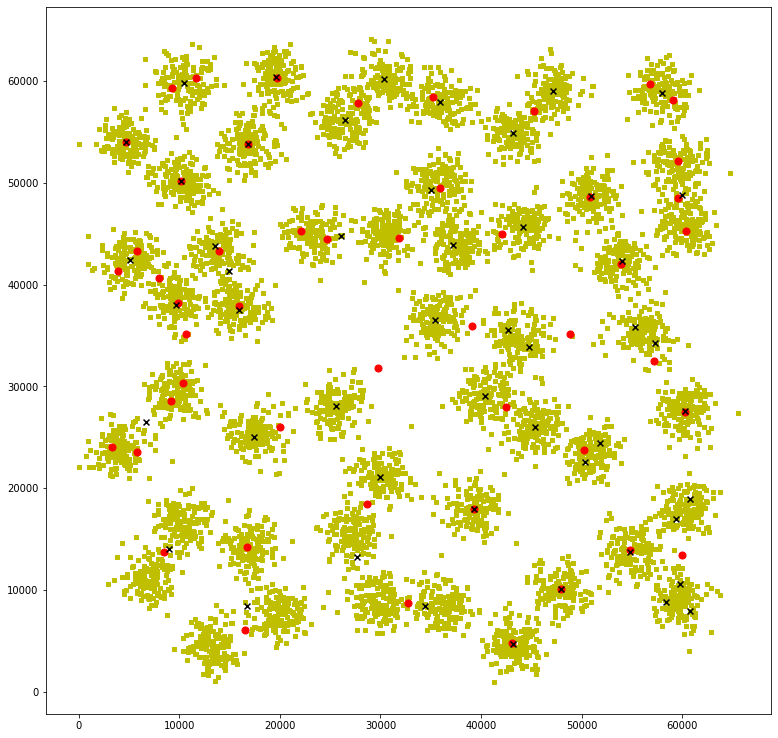

In [6]:
mllib_clusters = KMeans.train(parsed_data, 50, maxIterations=150, initializationMode="random")

xdata, ydata = np.hsplit(array(parsed_data.collect()), 2)

x, y = np.hsplit(array(centroids), 2) 
fig = plt.figure(figsize=(13, 13))
ax1 = fig.add_subplot(111)


x1, y1 = zip(*mllib_clusters.centers)

ax1.scatter(xdata, ydata, s=10, color='y', marker="s")
ax1.scatter(x, y, s=50, color='r', marker="o")
ax1.scatter(x1, y1, s=35, color='k', marker="x")

In [7]:
fields_filter = [1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0]
len(fields_filter)

42

In [8]:
def parse_kdd_line_filter_fields(line):
    split_line = line.strip().split(',')
    return array(tuple(map(float, compress(split_line, fields_filter))))
    
    
kdd_data = sc.textFile("../data/kddcup1999")
kdd_parsed_data_clean = kdd_data.map(parse_kdd_line_filter_fields)
kdd_parsed_data_clean.cache()

PythonRDD[97] at RDD at PythonRDD.scala:53

In [9]:
kdd_centroids = pkmeans(kdd_parsed_data_clean, 50)

Thu Dec  9 01:33:41 2021 Started


Thu Dec  9 01:34:29 2021 Iteration #1	Distance between old and new centroid: 281753.8284	Iteration took: 28.5018 sec


Thu Dec  9 01:35:04 2021 Iteration #2	Distance between old and new centroid: 16953537.1152	Iteration took: 35.5059 sec


Thu Dec  9 01:35:39 2021 Iteration #3	Distance between old and new centroid: 163070114.5510	Iteration took: 35.1141 sec


Thu Dec  9 01:36:15 2021 Iteration #4	Distance between old and new centroid: 397210560.6432	Iteration took: 35.9195 sec


Thu Dec  9 01:36:50 2021 Iteration #5	Distance between old and new centroid: 919724550.8622	Iteration took: 35.2182 sec


Thu Dec  9 01:37:26 2021 Iteration #6	Distance between old and new centroid: 94112881.6667	Iteration took: 35.4688 sec


Thu Dec  9 01:38:01 2021 Iteration #7	Distance between old and new centroid: 44540508.7098	Iteration took: 35.5407 sec


Thu Dec  9 01:38:36 2021 Iteration #8	Distance between old and new centroid: 139262098.4419	Iteration took: 35.1199 sec


Thu Dec  9 01:39:12 2021 Iteration #9	Distance between old and new centroid: 107121986.4497	Iteration took: 35.0547 sec


Thu Dec  9 01:39:47 2021 Iteration #10	Distance between old and new centroid: 1487586.9815	Iteration took: 35.0174 sec


Thu Dec  9 01:40:22 2021 Iteration #11	Distance between old and new centroid: 649459.2760	Iteration took: 35.3954 sec


Thu Dec  9 01:40:57 2021 Iteration #12	Distance between old and new centroid: 602691.0184	Iteration took: 35.2626 sec


Thu Dec  9 01:41:32 2021 Iteration #13	Distance between old and new centroid: 755197.6000	Iteration took: 34.9156 sec


Thu Dec  9 01:42:07 2021 Iteration #14	Distance between old and new centroid: 742209.0947	Iteration took: 35.3165 sec


Thu Dec  9 01:42:43 2021 Iteration #15	Distance between old and new centroid: 713942.7244	Iteration took: 35.2522 sec


Thu Dec  9 01:43:18 2021 Iteration #16	Distance between old and new centroid: 798335.3443	Iteration took: 35.3495 sec


Thu Dec  9 01:43:53 2021 Iteration #17	Distance between old and new centroid: 1827539.5773	Iteration took: 35.2352 sec


Thu Dec  9 01:44:29 2021 Iteration #18	Distance between old and new centroid: 475802.7331	Iteration took: 35.1862 sec


Thu Dec  9 01:45:04 2021 Iteration #19	Distance between old and new centroid: 637406.2784	Iteration took: 35.2902 sec


Thu Dec  9 01:45:39 2021 Iteration #20	Distance between old and new centroid: 69841.5752	Iteration took: 35.2965 sec


Thu Dec  9 01:46:15 2021 Iteration #21	Distance between old and new centroid: 31878.4587	Iteration took: 35.4414 sec


Thu Dec  9 01:46:50 2021 Iteration #22	Distance between old and new centroid: 20215.7737	Iteration took: 35.1394 sec


Thu Dec  9 01:47:25 2021 Iteration #23	Distance between old and new centroid: 17535.8302	Iteration took: 34.9495 sec


Thu Dec  9 01:48:00 2021 Iteration #24	Distance between old and new centroid: 37566.0784	Iteration took: 35.5249 sec


Thu Dec  9 01:48:35 2021 Iteration #25	Distance between old and new centroid: 47417.0908	Iteration took: 35.1366 sec


Thu Dec  9 01:49:11 2021 Iteration #26	Distance between old and new centroid: 29845.9453	Iteration took: 35.7296 sec


Thu Dec  9 01:49:47 2021 Iteration #27	Distance between old and new centroid: 29138.0771	Iteration took: 36.1086 sec


Thu Dec  9 01:50:22 2021 Iteration #28	Distance between old and new centroid: 29814.8374	Iteration took: 35.2392 sec


Thu Dec  9 01:50:59 2021 Iteration #29	Distance between old and new centroid: 29143.7082	Iteration took: 36.5017 sec


Thu Dec  9 01:51:34 2021 Iteration #30	Distance between old and new centroid: 37064.2678	Iteration took: 35.5156 sec


Thu Dec  9 01:52:11 2021 Iteration #31	Distance between old and new centroid: 41968.3229	Iteration took: 36.2816 sec


Thu Dec  9 01:52:46 2021 Iteration #32	Distance between old and new centroid: 89156.9530	Iteration took: 35.0282 sec


Thu Dec  9 01:53:21 2021 Iteration #33	Distance between old and new centroid: 94264.1499	Iteration took: 35.2912 sec


Thu Dec  9 01:53:57 2021 Iteration #34	Distance between old and new centroid: 127204.9171	Iteration took: 36.3634 sec


Thu Dec  9 01:54:33 2021 Iteration #35	Distance between old and new centroid: 55951.5841	Iteration took: 35.5276 sec


Thu Dec  9 01:55:09 2021 Iteration #36	Distance between old and new centroid: 35620.0405	Iteration took: 35.7468 sec


Thu Dec  9 01:55:45 2021 Iteration #37	Distance between old and new centroid: 36299.1137	Iteration took: 36.2541 sec


Thu Dec  9 01:56:20 2021 Iteration #38	Distance between old and new centroid: 25873.2519	Iteration took: 35.2200 sec


Thu Dec  9 01:56:57 2021 Iteration #39	Distance between old and new centroid: 17760.2901	Iteration took: 36.5414 sec


Thu Dec  9 01:57:35 2021 Iteration #40	Distance between old and new centroid: 13160.4785	Iteration took: 38.2179 sec


Thu Dec  9 01:58:12 2021 Iteration #41	Distance between old and new centroid: 9180.1372	Iteration took: 36.7014 sec


Thu Dec  9 01:58:48 2021 Iteration #42	Distance between old and new centroid: 18759.0535	Iteration took: 36.2252 sec


Thu Dec  9 01:59:24 2021 Iteration #43	Distance between old and new centroid: 14212.6457	Iteration took: 36.3880 sec


Thu Dec  9 02:00:00 2021 Iteration #44	Distance between old and new centroid: 9217.0561	Iteration took: 35.5977 sec


Thu Dec  9 02:00:36 2021 Iteration #45	Distance between old and new centroid: 6104.0839	Iteration took: 36.2540 sec


Thu Dec  9 02:01:14 2021 Iteration #46	Distance between old and new centroid: 3778.0939	Iteration took: 37.5607 sec


Thu Dec  9 02:01:51 2021 Iteration #47	Distance between old and new centroid: 4073.6617	Iteration took: 37.1141 sec


Thu Dec  9 02:02:28 2021 Iteration #48	Distance between old and new centroid: 3422.0697	Iteration took: 36.7044 sec


Thu Dec  9 02:03:06 2021 Iteration #49	Distance between old and new centroid: 4634.1005	Iteration took: 38.1637 sec


Thu Dec  9 02:03:43 2021 Iteration #50	Distance between old and new centroid: 3449.1214	Iteration took: 36.8866 sec


Thu Dec  9 02:04:18 2021 Iteration #51	Distance between old and new centroid: 2675.3489	Iteration took: 35.7994 sec


Thu Dec  9 02:04:56 2021 Iteration #52	Distance between old and new centroid: 2277.1946	Iteration took: 37.1765 sec


Thu Dec  9 02:05:36 2021 Iteration #53	Distance between old and new centroid: 2119.4597	Iteration took: 40.7470 sec


Thu Dec  9 02:06:14 2021 Iteration #54	Distance between old and new centroid: 2143.0631	Iteration took: 38.0730 sec


Thu Dec  9 02:06:50 2021 Iteration #55	Distance between old and new centroid: 1859.1072	Iteration took: 35.9407 sec


Thu Dec  9 02:07:27 2021 Iteration #56	Distance between old and new centroid: 1988.4475	Iteration took: 36.4654 sec


Thu Dec  9 02:08:03 2021 Iteration #57	Distance between old and new centroid: 2137.3359	Iteration took: 36.3353 sec


Thu Dec  9 02:08:38 2021 Iteration #58	Distance between old and new centroid: 2327.1794	Iteration took: 35.1826 sec


Thu Dec  9 02:09:15 2021 Iteration #59	Distance between old and new centroid: 2516.8913	Iteration took: 37.0047 sec


Thu Dec  9 02:09:50 2021 Iteration #60	Distance between old and new centroid: 10427.5681	Iteration took: 34.9689 sec


Thu Dec  9 02:10:25 2021 Iteration #61	Distance between old and new centroid: 8592.0025	Iteration took: 35.0188 sec


Thu Dec  9 02:11:00 2021 Iteration #62	Distance between old and new centroid: 7144.2831	Iteration took: 35.0903 sec


Thu Dec  9 02:11:36 2021 Iteration #63	Distance between old and new centroid: 7857.7357	Iteration took: 35.7809 sec


Thu Dec  9 02:12:12 2021 Iteration #64	Distance between old and new centroid: 5762.6746	Iteration took: 35.2718 sec


Thu Dec  9 02:12:49 2021 Iteration #65	Distance between old and new centroid: 8053.1910	Iteration took: 37.0213 sec


Thu Dec  9 02:13:24 2021 Iteration #66	Distance between old and new centroid: 14667.9965	Iteration took: 35.8110 sec


Thu Dec  9 02:14:00 2021 Iteration #67	Distance between old and new centroid: 14548.9341	Iteration took: 35.7668 sec


Thu Dec  9 02:14:37 2021 Iteration #68	Distance between old and new centroid: 15476.6571	Iteration took: 36.3558 sec


Thu Dec  9 02:15:13 2021 Iteration #69	Distance between old and new centroid: 16213.9676	Iteration took: 36.3811 sec


Thu Dec  9 02:15:48 2021 Iteration #70	Distance between old and new centroid: 18366.6273	Iteration took: 35.0733 sec


Thu Dec  9 02:16:23 2021 Iteration #71	Distance between old and new centroid: 18110.0326	Iteration took: 35.1245 sec


Thu Dec  9 02:16:59 2021 Iteration #72	Distance between old and new centroid: 20302.5548	Iteration took: 35.8123 sec


Thu Dec  9 02:17:34 2021 Iteration #73	Distance between old and new centroid: 44743.7490	Iteration took: 35.3710 sec


Thu Dec  9 02:18:11 2021 Iteration #74	Distance between old and new centroid: 45406.8635	Iteration took: 36.5271 sec


Thu Dec  9 02:18:50 2021 Iteration #75	Distance between old and new centroid: 57672.7301	Iteration took: 38.7908 sec


Thu Dec  9 02:19:29 2021 Iteration #76	Distance between old and new centroid: 130742.2147	Iteration took: 39.5254 sec


Thu Dec  9 02:20:06 2021 Iteration #77	Distance between old and new centroid: 115055.6864	Iteration took: 36.5249 sec


Thu Dec  9 02:20:41 2021 Iteration #78	Distance between old and new centroid: 164832.2662	Iteration took: 35.7880 sec


Thu Dec  9 02:21:17 2021 Iteration #79	Distance between old and new centroid: 241265.5053	Iteration took: 35.3859 sec


Thu Dec  9 02:21:52 2021 Iteration #80	Distance between old and new centroid: 304743.9624	Iteration took: 35.3302 sec


Thu Dec  9 02:22:29 2021 Iteration #81	Distance between old and new centroid: 259935.5452	Iteration took: 36.3700 sec


Thu Dec  9 02:23:06 2021 Iteration #82	Distance between old and new centroid: 304336.4163	Iteration took: 37.8882 sec


Thu Dec  9 02:23:42 2021 Iteration #83	Distance between old and new centroid: 238618.9687	Iteration took: 35.9016 sec


Thu Dec  9 02:24:17 2021 Iteration #84	Distance between old and new centroid: 179837.6076	Iteration took: 35.1362 sec


Thu Dec  9 02:24:53 2021 Iteration #85	Distance between old and new centroid: 201875.4918	Iteration took: 35.2483 sec


Thu Dec  9 02:25:28 2021 Iteration #86	Distance between old and new centroid: 179126.1432	Iteration took: 35.1741 sec


Thu Dec  9 02:26:03 2021 Iteration #87	Distance between old and new centroid: 6658.6744	Iteration took: 35.4314 sec


Thu Dec  9 02:26:39 2021 Iteration #88	Distance between old and new centroid: 3573.7382	Iteration took: 35.3761 sec


Thu Dec  9 02:27:14 2021 Iteration #89	Distance between old and new centroid: 5541.2924	Iteration took: 35.2271 sec


Thu Dec  9 02:27:51 2021 Iteration #90	Distance between old and new centroid: 11819.2778	Iteration took: 37.4573 sec


Thu Dec  9 02:28:28 2021 Iteration #91	Distance between old and new centroid: 7466.1764	Iteration took: 36.8931 sec


Thu Dec  9 02:29:05 2021 Iteration #92	Distance between old and new centroid: 7420.2775	Iteration took: 36.8294 sec


Thu Dec  9 02:29:41 2021 Iteration #93	Distance between old and new centroid: 5777.9206	Iteration took: 36.0370 sec


Thu Dec  9 02:30:16 2021 Iteration #94	Distance between old and new centroid: 4253.7985	Iteration took: 35.2205 sec


Thu Dec  9 02:30:52 2021 Iteration #95	Distance between old and new centroid: 9857.4600	Iteration took: 35.3942 sec


Thu Dec  9 02:31:27 2021 Iteration #96	Distance between old and new centroid: 5536.7562	Iteration took: 35.2112 sec


Thu Dec  9 02:32:02 2021 Iteration #97	Distance between old and new centroid: 3785.7330	Iteration took: 35.1090 sec


Thu Dec  9 02:32:37 2021 Iteration #98	Distance between old and new centroid: 3448.1715	Iteration took: 35.1728 sec


Thu Dec  9 02:33:13 2021 Iteration #99	Distance between old and new centroid: 3262.7464	Iteration took: 35.2797 sec


Thu Dec  9 02:33:48 2021 Iteration #100	Distance between old and new centroid: 6366.1848	Iteration took: 35.3091 sec


Thu Dec  9 02:34:23 2021 Iteration #101	Distance between old and new centroid: 2579.0153	Iteration took: 35.1374 sec


Thu Dec  9 02:34:58 2021 Iteration #102	Distance between old and new centroid: 4169.7295	Iteration took: 35.2189 sec


Thu Dec  9 02:35:33 2021 Iteration #103	Distance between old and new centroid: 7097.3708	Iteration took: 35.1548 sec


Thu Dec  9 02:36:09 2021 Iteration #104	Distance between old and new centroid: 12297.2129	Iteration took: 35.1980 sec


Thu Dec  9 02:36:44 2021 Iteration #105	Distance between old and new centroid: 6212.1109	Iteration took: 35.2623 sec


Thu Dec  9 02:37:19 2021 Iteration #106	Distance between old and new centroid: 5672.2247	Iteration took: 35.0972 sec


Thu Dec  9 02:37:55 2021 Iteration #107	Distance between old and new centroid: 8330.2774	Iteration took: 35.6805 sec


Thu Dec  9 02:38:30 2021 Iteration #108	Distance between old and new centroid: 6997.8151	Iteration took: 35.1411 sec


Thu Dec  9 02:39:05 2021 Iteration #109	Distance between old and new centroid: 3042.4515	Iteration took: 35.4091 sec


Thu Dec  9 02:39:41 2021 Iteration #110	Distance between old and new centroid: 2318.6429	Iteration took: 35.2785 sec


Thu Dec  9 02:40:16 2021 Iteration #111	Distance between old and new centroid: 6192.7091	Iteration took: 35.1208 sec


Thu Dec  9 02:40:51 2021 Iteration #112	Distance between old and new centroid: 5998.2071	Iteration took: 35.2449 sec


Thu Dec  9 02:41:26 2021 Iteration #113	Distance between old and new centroid: 10236.3015	Iteration took: 34.9659 sec


Thu Dec  9 02:42:01 2021 Iteration #114	Distance between old and new centroid: 6388.7834	Iteration took: 35.0099 sec


Thu Dec  9 02:42:36 2021 Iteration #115	Distance between old and new centroid: 7709.7161	Iteration took: 35.0792 sec


Thu Dec  9 02:43:11 2021 Iteration #116	Distance between old and new centroid: 5189.8555	Iteration took: 35.2989 sec


Thu Dec  9 02:43:46 2021 Iteration #117	Distance between old and new centroid: 5855.5604	Iteration took: 34.9496 sec


Thu Dec  9 02:44:22 2021 Iteration #118	Distance between old and new centroid: 5633.2390	Iteration took: 35.3848 sec


Thu Dec  9 02:44:57 2021 Iteration #119	Distance between old and new centroid: 3892.3521	Iteration took: 35.3120 sec


Thu Dec  9 02:45:32 2021 Iteration #120	Distance between old and new centroid: 2063.5405	Iteration took: 35.3305 sec


Thu Dec  9 02:46:07 2021 Iteration #121	Distance between old and new centroid: 1021.5992	Iteration took: 35.2511 sec


Thu Dec  9 02:46:43 2021 Iteration #122	Distance between old and new centroid: 633.5668	Iteration took: 35.0584 sec


Thu Dec  9 02:47:18 2021 Iteration #123	Distance between old and new centroid: 267.9114	Iteration took: 35.0577 sec


Thu Dec  9 02:47:53 2021 Iteration #124	Distance between old and new centroid: 490.4414	Iteration took: 35.6455 sec


Thu Dec  9 02:48:28 2021 Iteration #125	Distance between old and new centroid: 400.0523	Iteration took: 35.1990 sec


Thu Dec  9 02:49:04 2021 Iteration #126	Distance between old and new centroid: 594.5562	Iteration took: 35.4468 sec


Thu Dec  9 02:49:40 2021 Iteration #127	Distance between old and new centroid: 265.8438	Iteration took: 35.6688 sec


Thu Dec  9 02:50:15 2021 Iteration #128	Distance between old and new centroid: 303.0322	Iteration took: 35.4787 sec


Thu Dec  9 02:50:50 2021 Iteration #129	Distance between old and new centroid: 61.3756	Iteration took: 35.2384 sec


Thu Dec  9 02:51:26 2021 Iteration #130	Distance between old and new centroid: 47.6503	Iteration took: 35.2145 sec


Thu Dec  9 02:52:01 2021 Iteration #131	Distance between old and new centroid: 83.9894	Iteration took: 35.5800 sec


Thu Dec  9 02:52:36 2021 Iteration #132	Distance between old and new centroid: 57.7807	Iteration took: 35.1708 sec


Thu Dec  9 02:53:12 2021 Iteration #133	Distance between old and new centroid: 31.2777	Iteration took: 35.4773 sec


Thu Dec  9 02:53:47 2021 Iteration #134	Distance between old and new centroid: 22.2050	Iteration took: 35.3033 sec


Thu Dec  9 02:54:22 2021 Iteration #135	Distance between old and new centroid: 8.4411	Iteration took: 35.2530 sec


Thu Dec  9 02:54:57 2021 Iteration #136	Distance between old and new centroid: 4.3787	Iteration took: 35.1564 sec


Thu Dec  9 02:55:32 2021 Iteration #137	Distance between old and new centroid: 1.7688	Iteration took: 34.9728 sec


Thu Dec  9 02:56:08 2021 Iteration #138	Distance between old and new centroid: 0.3691	Iteration took: 35.1608 sec


Thu Dec  9 02:56:43 2021 Iteration #139	Distance between old and new centroid: 0.3882	Iteration took: 35.1981 sec


Thu Dec  9 02:57:18 2021 Iteration #140	Distance between old and new centroid: 0.0308	Iteration took: 35.3234 sec


Thu Dec  9 02:57:54 2021 Iteration #141	Distance between old and new centroid: 0.0000	Iteration took: 35.4354 sec


In [13]:
def calc_point_centroid_pairs(data, centroids) -> pyspark.rdd.RDD:
    return data.map(lambda point: (tuple(closest_centroid(point, centroids)), point))

def sum_of_squares_(centroid_points):
    s = 0
    points_ct = 0
    
    dim = len(centroid_points[0])    # get dimention of the point
    
    for centroid, points in centroid_points:
        centroid_arr = array(centroid)
        for point in points:
            s += euclidean_dist(point, centroid_arr)
            points_ct += 1    # count actual number of points in all the clusters
        points_ct -= 1        # required by the formula, reduce count by one
        
    return math.sqrt(s / (dim * points_ct))

def sum_of_squares_rmsstd(centroid_points):
    s = 0
    points_ct = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
        points_ct += 1
    
    return s, points_ct - 1  

def sum_of_squares_rs(centroid_points):
    s = 0
    
    centroid, points = centroid_points
    centroid_arr = array(centroid)
    
    for point in points:
        s += euclidean_dist(point, centroid_arr)
    
    return s

def rmsstd(data: pyspark.rdd.RDD, centroids):
    dim = len(data.first())
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    s, n = point_centroid_pairs.groupByKey().map(sum_of_squares_rmsstd).reduce(lambda x, y: (x[0] + y[0], x[1] + y[1]))
    return math.sqrt(s / (dim * n))

def rs(data: pyspark.rdd.RDD, centroids):
    g = data.mean()    # calc center of data
    sum_of_squares_total = data.map(lambda point: euclidean_dist(point, g)).sum()
    
    point_centroid_pairs = calc_point_centroid_pairs(data, centroids)
    sum_of_squres_clusters = point_centroid_pairs.groupByKey().map(sum_of_squares_rs).sum()
    
    return (sum_of_squares_total - sum_of_squres_clusters) / sum_of_squares_total
    


In [15]:
broad_kdd_centroids = sc.broadcast(kdd_centroids)
rmstd_kdd_custom = rmsstd(kdd_parsed_data_clean, kdd_centroids)
rmstd_kdd_custom

21/12/24 10:29:20 ERROR Executor: Exception in task 4.0 in stage 239.0 (TID 3501)
org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/rdd.py", line 992, in func
    initial = next(iterator)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_821720/1041054249.py", line 27, in sum_of_squa

Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 239.0 failed 1 times, most recent failure: Lost task 4.0 in stage 239.0 (TID 3501) (192.168.48.128 executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/rdd.py", line 992, in func
    initial = next(iterator)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_821720/1041054249.py", line 27, in sum_of_squares_rmsstd
  File "/tmp/ipykernel_821720/2762525019.py", line 2, in euclidean_dist
  File "<__array_function__ internals>", line 5, in sum
  File "/home/anton/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2259, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/anton/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
numpy.AxisError: axis 1 is out of bounds for array of dimension 1

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2236)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	at java.base/java.lang.Thread.run(Thread.java:829)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2258)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2207)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2206)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2206)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1079)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1079)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2445)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2387)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2376)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:868)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2196)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2217)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2236)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2261)
	at org.apache.spark.rdd.RDD.$anonfun$collect$1(RDD.scala:1030)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:414)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:1029)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:180)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at jdk.internal.reflect.GeneratedMethodAccessor49.invoke(Unknown Source)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:566)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.base/java.lang.Thread.run(Thread.java:829)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 604, in main
    process()
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 596, in process
    serializer.dump_stream(out_iter, outfile)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 259, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/rdd.py", line 992, in func
    initial = next(iterator)
  File "/home/anton/.local/lib/python3.9/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 73, in wrapper
    return f(*args, **kwargs)
  File "/tmp/ipykernel_821720/1041054249.py", line 27, in sum_of_squares_rmsstd
  File "/tmp/ipykernel_821720/2762525019.py", line 2, in euclidean_dist
  File "<__array_function__ internals>", line 5, in sum
  File "/home/anton/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 2259, in sum
    return _wrapreduction(a, np.add, 'sum', axis, dtype, out, keepdims=keepdims,
  File "/home/anton/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
numpy.AxisError: axis 1 is out of bounds for array of dimension 1

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:517)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:652)
	at org.apache.spark.api.python.PythonRunner$$anon$3.read(PythonRunner.scala:635)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:470)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator.foreach(Iterator.scala:941)
	at scala.collection.Iterator.foreach$(Iterator.scala:941)
	at org.apache.spark.InterruptibleIterator.foreach(InterruptibleIterator.scala:28)
	at scala.collection.generic.Growable.$plus$plus$eq(Growable.scala:62)
	at scala.collection.generic.Growable.$plus$plus$eq$(Growable.scala:53)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:105)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:49)
	at scala.collection.TraversableOnce.to(TraversableOnce.scala:315)
	at scala.collection.TraversableOnce.to$(TraversableOnce.scala:313)
	at org.apache.spark.InterruptibleIterator.to(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toBuffer(TraversableOnce.scala:307)
	at scala.collection.TraversableOnce.toBuffer$(TraversableOnce.scala:307)
	at org.apache.spark.InterruptibleIterator.toBuffer(InterruptibleIterator.scala:28)
	at scala.collection.TraversableOnce.toArray(TraversableOnce.scala:294)
	at scala.collection.TraversableOnce.toArray$(TraversableOnce.scala:288)
	at org.apache.spark.InterruptibleIterator.toArray(InterruptibleIterator.scala:28)
	at org.apache.spark.rdd.RDD.$anonfun$collect$2(RDD.scala:1030)
	at org.apache.spark.SparkContext.$anonfun$runJob$5(SparkContext.scala:2236)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:131)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$3(Executor.scala:497)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1439)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:500)
	at java.base/java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1128)
	at java.base/java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:628)
	... 1 more
